# Codificacion con transformadas

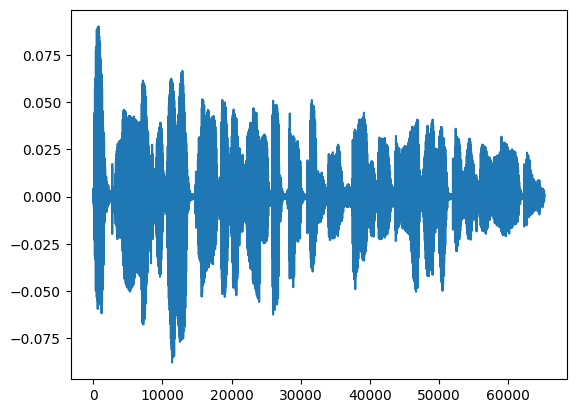

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import soundfile as sf
from scipy.fftpack import dct, idct


audio_path = "/Users/carlosedm10/projects/college/TDSC/Files/v1.wav"
audio, fs = sf.read(audio_path)

plt.plot(audio)
plt.show()

## Metodos

In [6]:
def _expand(signal, block_size):
    expanded_signal = []
    if len(signal) != block_size:
        # we add ceros to the signal until it reaches the block size
        expanded_signal = signal + [0] * (block_size - len(signal))
    else:
        expanded_signal = signal
    return expanded_signal


def divide_in_blocks(signal, block_size=64):
    blocks = []
    for i in range(0, len(signal), block_size):
        blocks.append(_expand(signal[i : i + block_size], block_size))
    return blocks


def divide_in_blocks_no_loops(signal: list, block_size: int = 64) -> np.array:
    # Calculate the required number of blocks
    num_blocks = int(np.ceil(len(signal) / block_size))

    # Calculate the total size required after zero-padding
    total_size = num_blocks * block_size

    # Zero-pad the signal to make its length a multiple of block_size
    padded_signal = np.pad(signal, (0, total_size - len(signal)), mode="constant")

    # Reshape the padded signal into a matrix with block_size rows
    blocks = padded_signal.reshape(
        num_blocks, block_size
    )  # Transpose for column-major order like MATLAB

    return blocks


def undo_blocks(blocks: np.array, original_length: int) -> np.array:
    """
    Converts the matrix of blocks back into a single vector.

    Parameters:
        blocks (np.array): The matrix of blocks (block_size x num_blocks).
        original_length (int): The original length of the signal (before zero-padding).

    Returns:
        np.array: The reconstructed signal as a 1D vector.
    """
    # Flatten the matrix into a single vector
    reconstructed_signal = blocks.flatten()

    # Remove any zero-padding added during the division into blocks
    reconstructed_signal = reconstructed_signal[:original_length]

    return reconstructed_signal


def _compute_variance(blocks):
    return [np.var(block) for block in blocks]


def compactation_gain(blocks):
    """
    This function computes the compactation gain of the signal calculating the variance of each block and then applying the formula:
    G = MA(variance)/MG(variance)
    """
    variance = _compute_variance(blocks)

    mean = np.mean(variance)
    geo_mean = np.exp(np.mean(np.log(variance)))

    return mean / geo_mean


def filtered_coeficients(c, m):
    """
    This method only selects the m-first coefficients of the DCT transform
    """
    reconstructed = []
    for block in c:
        c_prime = np.zeros_like(block)
        c_prime[:m] = block[:m]
        reconstructed.append(c_prime)
    return reconstructed

# Ejercicio 1

Signal Gain: 3.0518771811685923
Transform Gain: 1.7172096431370145


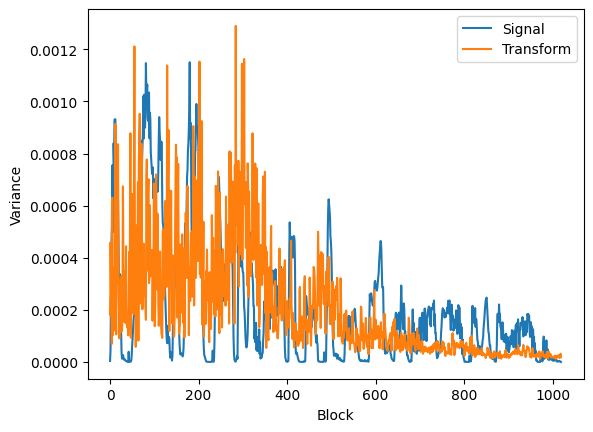

In [7]:
x = divide_in_blocks_no_loops(audio)
x_t = (x.copy()).T

variance = _compute_variance(x_t)
print("Signal Gain:", compactation_gain(x_t))

c = dct(x, axis=0, norm="ortho")
c_t = dct(x_t, axis=0, norm="ortho")
c_variance = _compute_variance(c_t)

# Gain of the DCT transform
print("Transform Gain:", compactation_gain(c))

# Plot both variances
plt.plot(variance)
plt.plot(c_variance)
plt.legend(["Signal", "Transform"])
plt.ylabel("Variance")
plt.xlabel("Block")
plt.show()

# Ejercicio 2

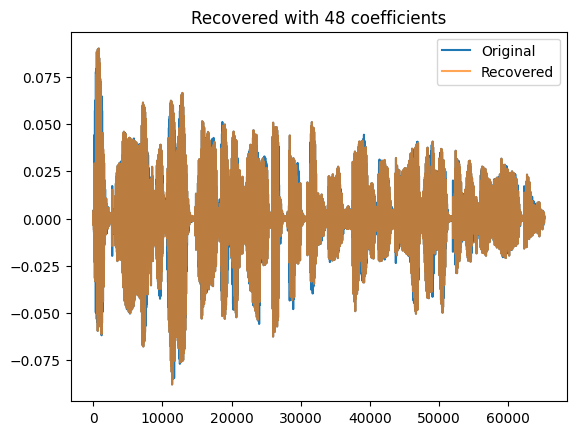

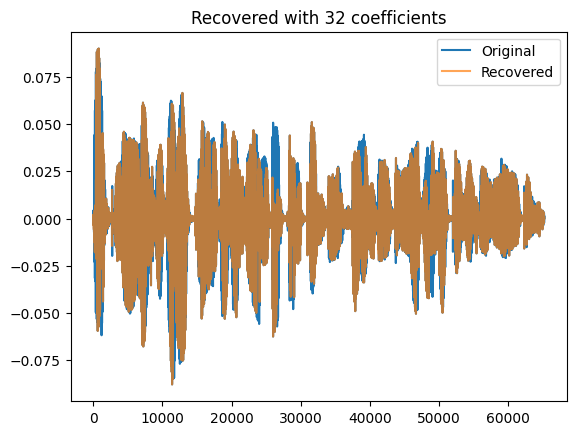

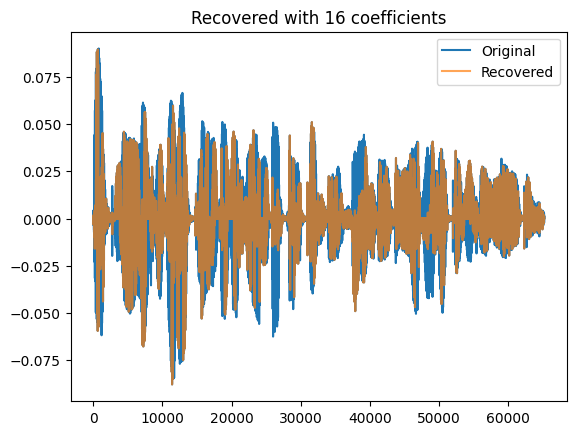

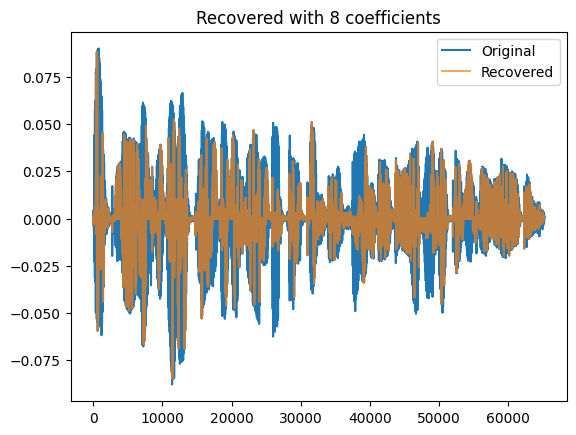

In [8]:
for m in [48, 32, 16, 8]:
    filtered_blocks = filtered_coeficients(c, m)

    reconstructed_blocks = idct(filtered_blocks, axis=0, norm="ortho")
    recovered_signal = undo_blocks(reconstructed_blocks, len(audio))

    plt.title(f"Recovered with {m} coefficients")
    plt.plot(audio)
    plt.plot(recovered_signal, alpha=0.7)
    plt.legend(["Original", "Recovered"])
    plt.show()